# Dataset Curation

Historical data for BSE Sensex is obtained from [Yahoo Finance](https://finance.yahoo.com/quote/%5EBSESN/history?period1=1420070400&period2=1660003200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true). 

We entered the start and end dates and copied the entries from the table element on the yahoo finance website and stored them as `yahoo_finance_bse_historical_table.html` file. We will now use beautiful-soup to parse the html table information into a pandas dataframe for subsequent analysis.


In [1]:
# Install all the necessary libraries
# Only do this once at the beginning of running the notebook
# !pip install -q beautifulsoup4 pandas numpy scikit-learn matplotlib prophet seaborn statsmodels pmdarima torch pytorch-lightning

In [2]:
# Get all the libraries
import re
import warnings
from copy import deepcopy
from pathlib import Path
from typing import List, Tuple

import bs4
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup

# warnings.filterwarnings("ignore")

plt.style.use("ggplot")
%matplotlib inline

In [3]:
# Read the HTML Table for getting historical records
html_doc = Path("yahoo_finance_bse_historical_table.html").read_text()
soup = BeautifulSoup(html_doc, "html.parser")

# Column Headers
columns = [x.text for x in soup.find("thead").find_all("span")]

# Read the table rows
table_body = soup.find("tbody")
table_rows = table_body.find_all("tr")

# Extract information from each and every individual row
empty_dates = []


def extract_info(row: bs4.element.Tag) -> List:
    """Given a table row, extract all information pertaining to that day's record

    Args:
        row (bs4.element.Tag): An individual row in the table

    Returns:
        List: List of lists, each individual list has several markers like open, close, high, low etc.
    """
    elements = []

    # Iterate over all the elements in the table row
    for item in row.find_all("td"):
        # If there is some text in this column of the row, accumulate it in elements
        if item.span:
            elements.append(item.span.text)
        # In some cases, we have instances of empty rows, indicate that with a -1
        else:
            elements.append("-1")
    elements = [elements[0]] + [float(re.sub(",", "", x)) for x in elements[1:]]
    return elements


# Get all the rows and subsequently create a dataframe
# Invert the entries to go from earlier to later timeperiods
records = [extract_info(x) for x in table_rows][::-1][1:]

In [4]:
# Make a dataframe of all the records
df = pd.DataFrame(records, columns=columns)
df = df[df.Open != -1].reset_index(drop=True)
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)

# Remove special trading entries which happen on Saturday/Sunday
# to have a consistent time period of business days only
df = df[df.Date.dt.weekday.apply(lambda x: x in [0, 1, 2, 3, 4])].reset_index(drop=True)

# Keep only the data till Jun 2021 as that's the range asked for in the question
# Include data till the last working week of June to maintain data consistency
df = df[df.Date < "07-04-2021"].reset_index(drop=True)
df.index = df["Date"]
df.tail(10)

,Date,Open,High,Low,Close*,Adj Close**,Volume
Date,,,,,,,
2021-06-21,2021-06-21,51887.55,52629.18,51740.19,52574.46,52574.46,12500.0
2021-06-22,2021-06-22,52885.04,53057.11,52520.55,52588.71,52588.71,7700.0
2021-06-23,2021-06-23,52912.35,52912.35,52264.12,52306.08,52306.08,13600.0
2021-06-24,2021-06-24,52514.57,52830.68,52385.05,52699.00,52699.00,7900.0
2021-06-25,2021-06-25,52877.16,52973.07,52614.49,52925.04,52925.04,10700.0
2021-06-28,2021-06-28,53126.73,53126.73,52673.50,52735.59,52735.59,6200.0
2021-06-29,2021-06-29,52795.76,52816.42,52477.77,52549.66,52549.66,9200.0
2021-06-30,2021-06-30,52651.09,52875.92,52448.64,52482.71,52482.71,9500.0
2021-07-01,2021-07-01,52638.50,52638.50,52281.01,52318.60,52318.60,5800.0


In [5]:
# Have a look at the holidays encountered in this period and fill them in the dataset.
# Make sure to add a flag indicating whether this day is a holiday or not
idxs = []
offset = 0
for idx, entry in enumerate(df.Date.dt.weekday):
    if (idx + offset) % 5 != entry:
        offset += 1
        idxs.append(idx)

from pandas.tseries.offsets import BDay

(df.iloc[idxs, :].Date - BDay(1))[:3]

Date
2015-01-27   2015-01-26
2015-02-18   2015-02-17
2015-03-09   2015-03-06
Name: Date, dtype: datetime64[ns]

From the table above, we can see that there's some fixed holidays which recurringly occur over the course of years like `Republic Day, Mahashivratri, Holi, Good Friday, Eid etc.`.

We can add these to our dataset, use forwardfill to carry over the information from the previous day to the current day and add an indicator showing that this particular day was a holiday. This will ensure we have a contiguous chronological sequence with no gaps and also we'll use the holiday as an exogenuos variable to let the model know we're carrying forward this info as is to preserve the integrity of the dataset

In [6]:
# Create a business day daterange object starting from lowest to highest day
new_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="B")

# Use ffill i.e. fill the latest available value forward
reindexed_df = df.reindex(new_date_range, method="pad")

In [7]:
# Create a column which reflects if we've substituted a missing value for
# all the holidays/off-days or not
missing_dates = set(reindexed_df.index) - set(df.index)
missing_indicator = (
    reindexed_df.index.map(lambda x: x in missing_dates) * 1.0
).tolist()
reindexed_df["Holiday"] = missing_indicator
df = reindexed_df

We have now collected data for `BSE Sensex` index right from the year `2015` upto the current day. However, we can truncate the dataset till `June 2021` since the problem statement expects us to only predict till that point in time.

We have the following columns in our dataset

- Date: The date corresponding to which the information is presented
- Open: What was the opening index amount
- High: What was the highest that the index touched for that day
- Low: What was the lowest that the index touched for that day
- Close: What was the closing index amount (Our Prediction Value)
- Volume: An indicator of the amount of trades happening within the given day
- Adj Close: Adjusted close price adjusted for splits/dividends and other capital gain distributions

# Task Definition

We have the information related to BSE Sensex Index from the second of January 2015 to date. We are wanting to predict the close price of the index everyday for the period `Apr' 21 to Jun'21` and using data before that time period to train our model.

The data is collected on a per day basis. Reasons for selecting the granularity as `1 day`:

- The output expects us to predict daily prices in the `April'21 - June'21` Range. So, it makes sense to have the train data at the same granularity as the test data.

- We could also fit an hourly/minutely model and then predict on the last hour/ last minute for the April'21 or June'21 period. However that would make the problem of fetching the data and subsequently processing it very complex. Hence, we chose to restrict ourselves to a per day frequency for this task.

# Model Building and Evaluation

## Modelling with SARIMAX

We will model this problem as a time-series forecasting problem with `close` as the `label` or target variable.

Since we're modelling the problem as a time-series problem, we can only use

- Historical data about the index

- Exogenous Predictors: Variables which are predetermined and will still impact the index value in the future.

This means, we will not be able to make use of `Open`, `High`, `Low` and `Volume` factors in our analysis since they're not known beforehand!

**Why?**

Because we're assuming we're standing on March 31, 2021 and looking to predict values for April through June 2021. This means no transactions have happened as yet and the values of these features are not yet known to us. We will need to create features that are exogenous.

We already have the date which is a really strong feature. We could extract

- DW: Day of the week
- MM: Month of the year
- QT: Quarter to which the day belongs

Decomposing the date into these three components and treating them as categorical exogenous variables is possible as these values are fixed in the future and there's no uncertainty in these features 

In [8]:
# Engineer features related to time i.e. day of week, month of year, quarter etc.
df["DOW"] = df.index.day_name()
df["MOY"] = df.index.month_name()
df["Q"] = df.index.quarter
df["Q"] = df.Q.apply(lambda x: str(x))
df.drop(columns=["Open", "High", "Low", "Adj Close**", "Volume"], inplace=True)

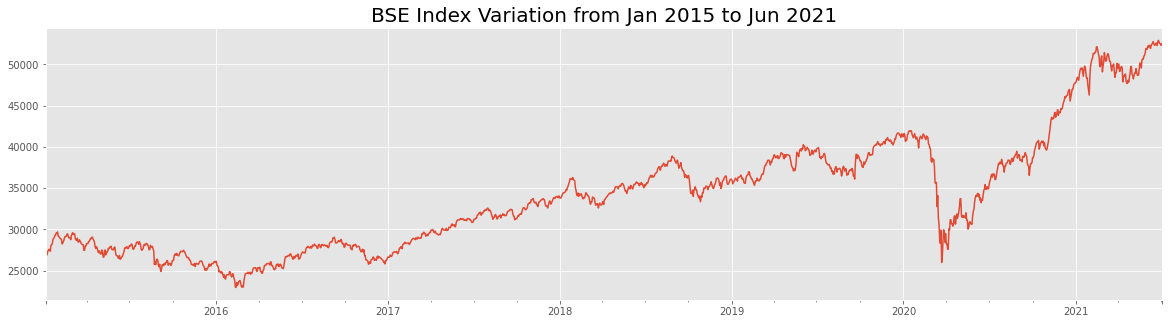

In [9]:
plt.figure(figsize=(20, 5))
df["Close*"].plot()
plt.title("BSE Index Variation from Jan 2015 to Jun 2021", fontsize=20);

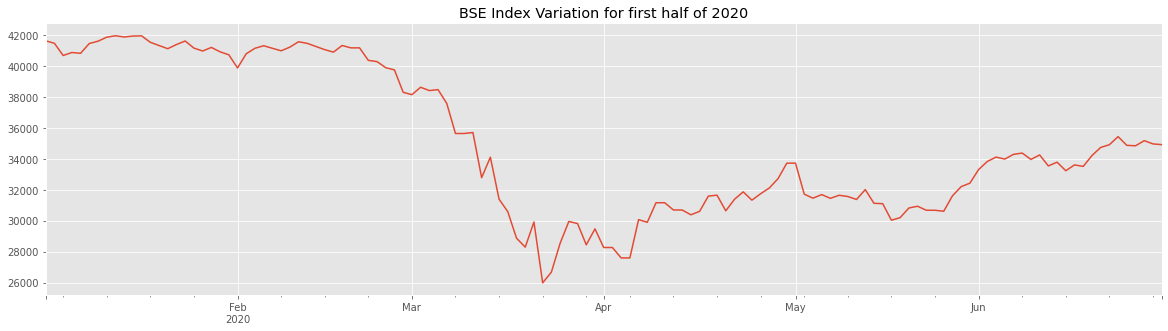

In [10]:
# Zoom into the COVID period to see how the index was performing
plt.figure(figsize=(20, 5))
df[(df.index > "01-01-2020") & (df.index < "07-01-2020")]["Close*"].plot()
plt.title("BSE Index Variation for first half of 2020");

We can see that the market has over and above continued to rise steadily over time. However there's a huge dip in the period spanning from `Jan 2020 - April 2020`. This is the time when COVID struck adversely and most of the industries and work had come to a standstill. 

Let us try and analyse the `Close` index a little more closely.

We shall decompose the Close index values and assume a seasonality of 5 since we have 5 working days every week.

In [11]:
# Decompose the series into it's individual components and inspect the different components
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df["Close*"])

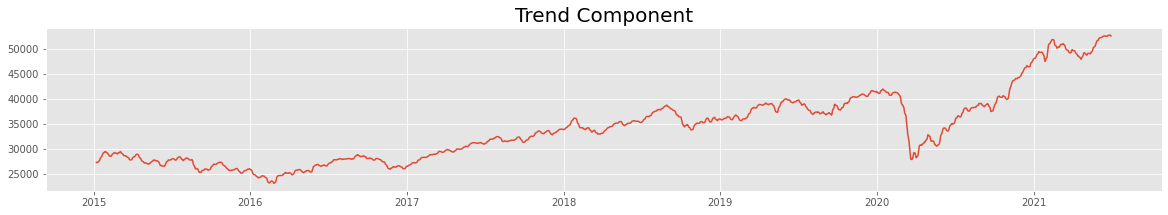

In [12]:
# Examine trend part of the result
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
plt.plot(df.index.tolist(), result.trend)
plt.title("Trend Component", fontsize=20);

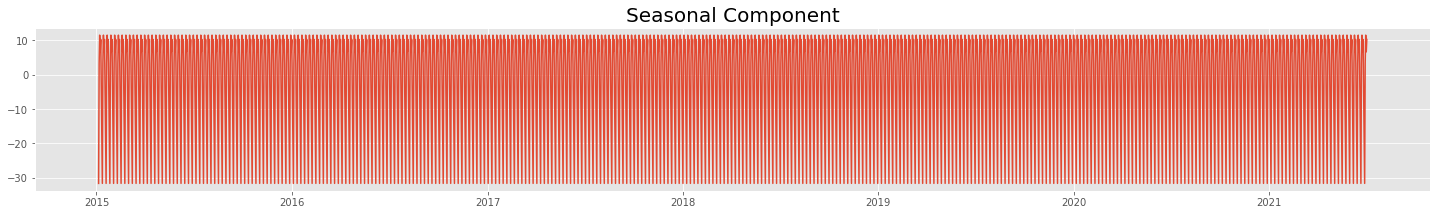

In [13]:
# Examine the seasonal part of the result
fig, ax = plt.subplots(1, 1, figsize=(25, 3))
plt.plot(df.index.tolist(), result.seasonal)
plt.title("Seasonal Component", fontsize=20);

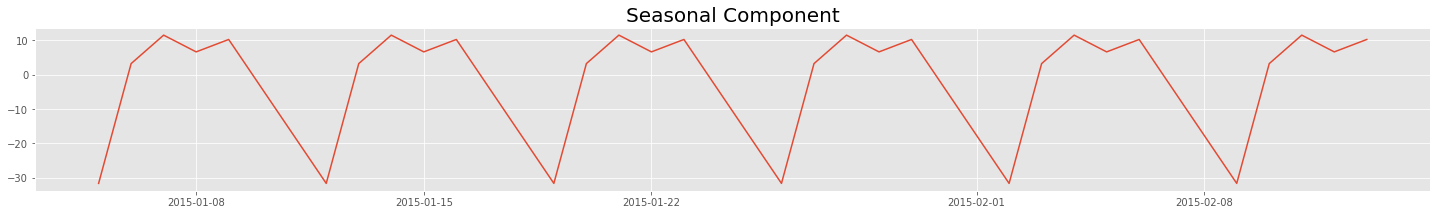

In [14]:
# Examine a small portion of the seasonal component
fig, ax = plt.subplots(1, 1, figsize=(25, 3))
plt.plot(df.index.tolist()[:30], result.seasonal[:30])
plt.title("Seasonal Component", fontsize=20);

Looking at the plot above, we can say there's a very strong seasonality aspect in the data over a given week. This is to be expected since we know the markets are closed every weekend and there's a weekly seasonality inherent to these index values.

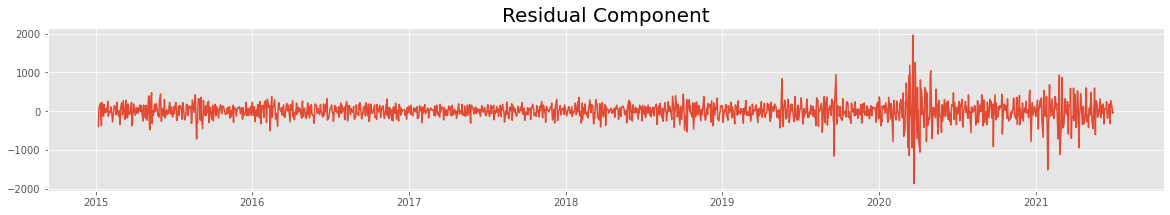

In [15]:
# Look at the residual/error part of the result
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
plt.plot(df.index.tolist(), result.resid)
plt.title("Residual Component", fontsize=20);

From the residual component part, we can see there are several events which are very interesting.

- In the second half of 2015, there was a noticable dip which could be attributed to fears over slowdown in China.
- In the late 2019, COVID originated in China and there was a substantial movement in the index then.
- In mid-2020, COVID hit India adversely at it's worst and the residual in the index reflects that motion very visibly.
- In the early half of 2021, subsequent waves of COVID hit India adversely leading to a high unpredictability in the market index.

Now that we have some knowledge about the index movement, let us preprocess the dataset (i.e. handle categorical variables) so that we can build a `SARIMAX` model out of it.

We can handle these variables by using OneHotEncoder from sklearn or the get_dummies function from pandas.

In [16]:
from sklearn.preprocessing import OneHotEncoder

# Use the OneHotEncoder from sklearn, drop the first level in any given category
# This is to ensure no multicollinearity/redundancy in the feature space
OHE = OneHotEncoder(handle_unknown="ignore", drop="first")
cat_cols = ["DOW", "MOY", "Q"]
OHE.fit(df[cat_cols])
df_categorical = pd.DataFrame(
    OHE.transform(df[cat_cols]).toarray(),
    columns=OHE.get_feature_names_out(),
    index=df.index,
)
df_categorical.head(2)

,DOW_Monday,DOW_Thursday,DOW_Tuesday,DOW_Wednesday,MOY_August,MOY_December,MOY_February,MOY_January,MOY_July,MOY_June,MOY_March,MOY_May,MOY_November,MOY_October,MOY_September,Q_2,Q_3,Q_4
2015-01-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-06,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Add all the categorical columns and drop the original columns
final_df = pd.concat([df, df_categorical], axis=1)
final_df.drop(columns=["DOW", "MOY", "Q", "Date"], inplace=True)
final_df.head(3)

,Close*,Holiday,DOW_Monday,DOW_Thursday,DOW_Tuesday,DOW_Wednesday,MOY_August,MOY_December,MOY_February,MOY_January,MOY_July,MOY_June,MOY_March,MOY_May,MOY_November,MOY_October,MOY_September,Q_2,Q_3,Q_4
2015-01-05,27842.32,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-06,26987.46,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-07,26908.82,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create an auto-arima model and figure out the AR (Auto regressive), D (For making the time series stationary), MA (Moving Average terms) and Seasonal components and then fit a model.

In [18]:
from pmdarima import auto_arima

auto_arima(final_df["Close*"], seasonal=True, m=5).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1695
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 5)   Log Likelihood              -12414.701
Date:                             Sun, 28 Aug 2022   AIC                          24847.402
Time:                                     20:33:44   BIC                          24896.315
Sample:                                          0   HQIC                         24865.513
                                            - 1695                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.0776      9.267      1.411      0.158      -5.085      31.240
ar.L1         -1.6155      0.049    -33.286      0.000      -1.711      -1.520
ar.L2         -0.8256      0.058    -14.117      0.000      -0.940      -0.711
ar.L3          0.0415      0.017      2.481      0.013       0.009       0.074
ma.L1          1.6086      0.045     35.420      0.000       1.520       1.698
ma.L2          0.8471      0.046     18.462      0.000       0.757       0.937
ar.S.L5        0.8393      0.057     14.597      0.000       0.727       0.952
ma.S.L5       -0.7868      0.067    -11.734      0.000      -0.918      -0.655
sigma2      1.377e+05   2052.762     67.074      0.000    1.34e+05    1.42e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):             12335.77
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               4.59   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
train = final_df[final_df.index <= "2021-03-31"]
test = final_df[final_df.index > "2021-03-31"]

Now that we're aware of the components of the SARIMAX, we can build the model by splitting our original dataset into train and test sets

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train["Close*"],
    exog=train.drop(columns=["Close*"]),
    order=(3, 1, 2),
    seasonal_order=(1, 0, 1, 5),
    enforce_invertibility=False,
)
results = model.fit()
results.summary()

/home/vinayak/anaconda3/envs/paddy/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79011D+00    |proj g|=  1.40661D-01

At iterate    5    f=  7.47609D+00    |proj g|=  2.70027D-01

At iterate   10    f=  7.34879D+00    |proj g|=  3.51515D-01

At iterate   15    f=  7.31703D+00    |proj g|=  2.69850D-02

At iterate   20    f=  7.31408D+00    |proj g|=  4.60306D-02

At iterate   25    f=  7.31185D+00    |proj g|=  3.42183D-02

At iterate   30    f=  7.31178D+00    |proj g|=  7.09560D-03

At iterate   35    f=  7.31176D+00    |proj g|=  2.93513D-03

At iterate   40    f=  7.31176D+00    |proj g|=  5.82763D-04

At iterate   45    f=  7.31172D+00    |proj g|=  2.02698D-02

At iterate   50    f=  7.31157D+00    |proj g|=  2.93608D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/vinayak/anaconda3/envs/paddy/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              Close*   No. Observations:                 1628
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 5)   Log Likelihood              -11903.229
Date:                             Sun, 28 Aug 2022   AIC                          23860.458
Time:                                     20:33:52   BIC                          24006.109
Sample:                                 01-05-2015   HQIC                         23914.497
                                      - 03-31-2021                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Holiday          12.0682     33.354      0.362      0.717     -53.305      77.441
DOW_Monday      -40.9786     23.567     -1.739      0.082     -87.168       5.211
DOW_Thursday     -5.4460     25.405     -0.214      0.830     -55.238      44.346
DOW_Tuesday      -5.3704     30.558     -0.176      0.860     -65.263      54.522
DOW_Wednesday     5.3766     30.308      0.177      0.859     -54.026      64.780
MOY_August      -16.3788    125.238     -0.131      0.896    -261.840     229.083
MOY_December    -65.0231    182.606     -0.356      0.722    -422.924     292.878
MOY_February    -19.1119    124.858     -0.153      0.878    -263.830     225.606
MOY_January    -249.4639    131.815     -1.893      0.058    -507.817       8.890
MOY_July        248.1086    158.078      1.570      0.117     -61.718     557.936
MOY_June         36.9706    453.139      0.082      0.935    -851.166     925.107
MOY_March       188.3345    134.887      1.396      0.163     -76.040     452.709
MOY_May        -124.7517    451.110     -0.277      0.782   -1008.911     759.408
MOY_November     -8.3805    160.556     -0.052      0.958    -323.064     306.303
MOY_October       7.6593    208.724      0.037      0.971    -401.433     416.751
MOY_September  -191.8520    145.070     -1.322      0.186    -476.185      92.481
Q_2             106.1078    147.244      0.721      0.471    -182.484     394.700
Q_3              39.8778    245.684      0.162      0.871    -441.654     521.410
Q_4             -65.7443    197.266     -0.333      0.739    -452.378     320.889
ar.L1             1.3187      0.018     72.087      0.000       1.283       1.355
ar.L2            -0.9323      0.024    -39.101      0.000      -0.979      -0.886
ar.L3            -0.0308      0.015     -2.059      0.039      -0.060      -0.001
ma.L1            -1.3668      0.013   -107.066      0.000      -1.392      -1.342
ma.L2             1.0236      0.013     79.908      0.000       0.998       1.049
ar.S.L5           0.5517      0.110      4.999      0.000       0.335       0.768
ma.S.L5          -0.4456      0.120     -3.702      0.000      -0.682      -0.210
sigma2         1.327e+05   4013.355     33.058      0.000    1.25e+05    1.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):             12259.19
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               4.43   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condit

In [21]:
# Obtain the predicted values
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(
    start=start, end=end, exog=test.drop(columns=["Close*"]), index=test.index
).rename("Predicted Close*")

## SARIMAX Model Evaluation

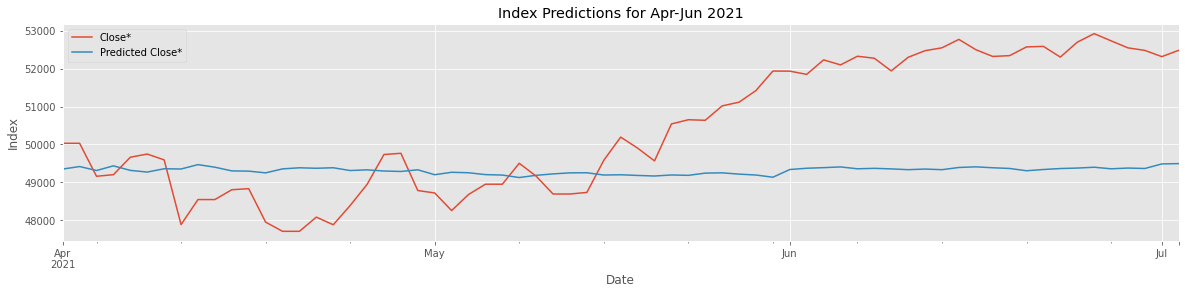

In [22]:
# Plot predictions against known values
title = "Index Predictions for Apr-Jun 2021"
ylabel = "Index"
xlabel = "Date"

ax = test["Close*"].plot(legend=True, figsize=(20, 4), title=title)
residuals = test["Close*"] - predictions
predictions.plot(legend=True)
ax.autoscale(axis="x", tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

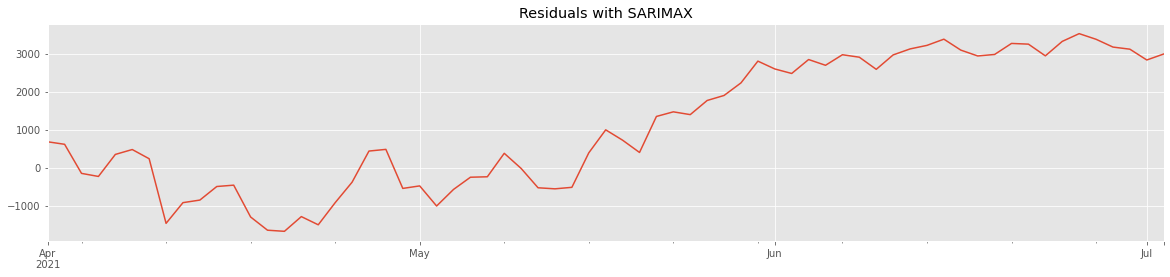

In [23]:
plt.figure(figsize = (20,4))
residuals = test["Close*"] - predictions
residuals.plot();
plt.title("Residuals with SARIMAX");

We can see that we are underpredicting in the beginning and post May'21 we're overpredicting.

In [24]:
# Evaluate the performance of the SARIMA Model
# Check the RMSE and RMSPE on train and test sets

train_preds = results.predict(
    start=0, end=len(train) - 1, exog=train.drop(columns=["Close*"]), index=train.index
).rename("Predicted Close*")

train_rmse = ((train_preds - train["Close*"]) ** 2).sum() ** 0.5
test_rmse = ((predictions - test["Close*"]) ** 2).sum() ** 0.5

train_rmspe = (((train["Close*"] - train_preds) / (train["Close*"])) ** 2).mean() ** 0.5
test_rmspe = (((test["Close*"] - predictions) / (test["Close*"])) ** 2).mean()

print(f"Train RMSE: {train_rmse:.3f}\t Test RMSE: {test_rmse:.3f}")
print(f"Train RMSPE: {train_rmspe * 100:.3f}%\t Test RMSPE: {test_rmspe * 100:.3f}%")
print(
    f'Train Mean: {train["Close*"].mean():.3f}\t Test Mean: {test["Close*"].mean():.3f}'
)
print(f'Train Std: {train["Close*"].std():.3f}\t Test Std: {test["Close*"].std():.3f}')

Train RMSE: 31729.069	 Test RMSE: 16421.396
Train RMSPE: 2.738%	 Test RMSPE: 0.149%
Train Mean: 33394.682	 Test Mean: 50409.678
Train Std: 6240.923	 Test Std: 1715.854


## Modelling with Prophet 

Prophet is a library which is curated by facebook particularly for time-series forecasting problems.

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

It is known to work well with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [25]:
# We only need the date and series columns and not anything else from the original dataframe
prophet_df = deepcopy(df[["Date", "Close*"]])

In [26]:
# Split the dataframe into train and test
train_df = prophet_df[prophet_df.Date <= "2021-03-31"].reset_index(drop=True)
test_df = prophet_df[prophet_df.Date > "2021-03-31"].reset_index(drop=True)

In [27]:
# Prophet needs it's columns to be named as follows
# Date Column -> ds
# Actual Time Series column -> y
train_df.columns = ["ds", "y"]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1628 non-null   datetime64[ns]
 1   y       1628 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.6 KB


In [28]:
from prophet import Prophet

m = Prophet()
m.fit(train_df)

20:33:53 - cmdstanpy - INFO - Chain [1] start processing
20:33:53 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# Create a dataframe for future perdictions in the prophet format
# And predict the values of the Index
test_dates = m.make_future_dataframe(periods=67, freq="B")
forecast = m.predict(test_dates)

predictions = forecast[["ds", "yhat"]]
predictions = predictions[predictions.ds > "2021-03-31"]
predictions.index = predictions.ds

## Prophet Model Evaluation

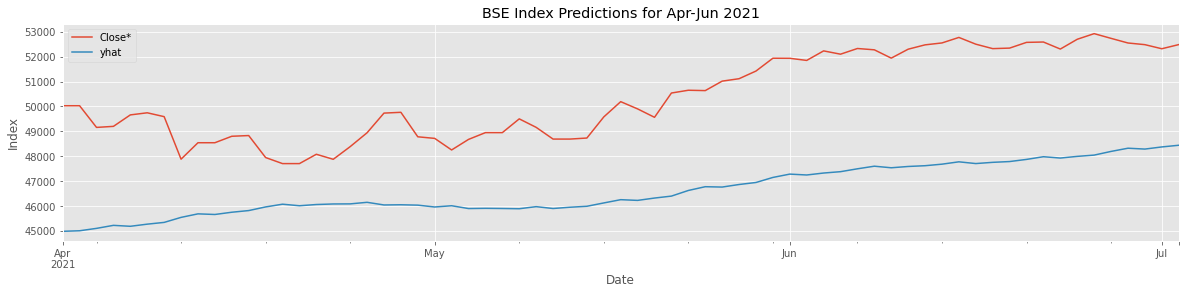

In [30]:
# Plot predictions against known values
title = "BSE Index Predictions for Apr-Jun 2021"
ylabel = "Index"
xlabel = "Date"

ax = test["Close*"].plot(legend=True, figsize=(20, 4), title=title)
predictions["yhat"].plot(legend=True)
ax.autoscale(axis="x", tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [31]:
trues = test["Close*"].values
preds = predictions["yhat"].values

error = ((trues - preds) ** 2).sum() ** 0.5
rmspe = (abs(trues - preds) / trues).mean() * 100

print(f"Prophet Test RMSE: {error:.3f} RMSPE: {rmspe:.3f}%")

Prophet Test RMSE: 31916.414 RMSPE: 7.447%


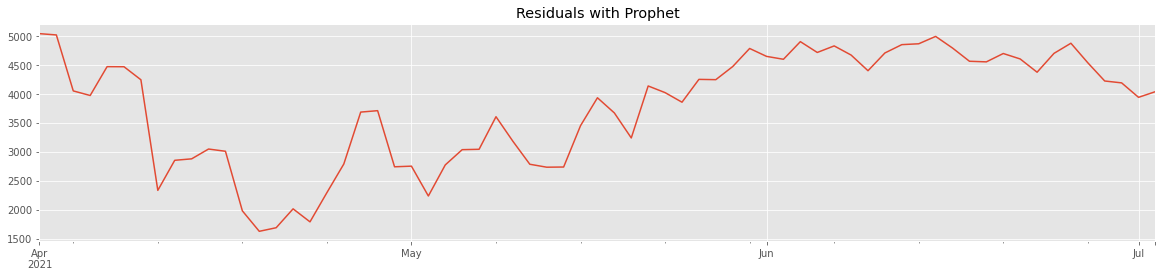

In [32]:
plt.figure(figsize = (20,4))
residuals = test["Close*"] - predictions["yhat"]
residuals.plot();
plt.title("Residuals with Prophet");

We can see that the prophet model has seemingly captured the increasing trend but it is consistently underpredicting throughout the time-series as seen from the positive residuals throughout the time series.

In comparison with Prophet, the SARIMA Model with exogenous variables seems to have done a better job at forecasting the future values of the BSE index for the given time period.

## Modelling with DL Based Prediction Methods

**LSTM Model**

For modelling sequence data, Recurrent Neural Networks are used. In addition to the normal feed-forward neural networks, these networks have a time dimension or the sequence dimension to which inputs are fed recurrently. The architecture looks somewhat as follows

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

However, RNNs face the issue of vanishing gradients very adversely and don't remember long back in the past. LSTMs which are a flavor of RNN mitigate this issue to a substantial degree. They have internal gating mechanisms to selectively remember information pertinent to the task at hand retrospectively to a larger degree than RNNs and forget unnecessary information. A typical LSTM cell looks as follows

![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

In the following cells, we've implemented LSTM with exogeneous inputs in order to be able to leverage time related information in a better way. Our architecture is as follows

![](./Architecture_Diagram.jpg)

In [33]:
# Suppress the warnings
import warnings

import numpy as np

# Import the wrapper for training
import pytorch_lightning as pl

# For defining the model
import torch
import torch.nn as nn
import torch.nn.functional as F

# For preprocessing the time series to fit into a standardized scale (Z-Standardized)
from sklearn.preprocessing import StandardScaler
from torch.nn.modules import *

# For curating the data and feeding it into our DL Models
from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings("ignore")

In [34]:
# For categorical features, encode them with labels
# Here it's simply time related features and holidays so it's quite straightforward
dow = df.DOW.unique().tolist()
moy = df.MOY.unique().tolist()
qtr = df.Q.unique().tolist()

df["DOW"] = df.DOW.apply(lambda x: dow.index(x))
df["MOY"] = df.MOY.apply(lambda x: moy.index(x))
df["Q"] = df.Q.apply(lambda x: qtr.index(x))

In [35]:
# Create separate dataframes for training and testing
train_df = deepcopy(df[df.index <= "2021-03-31"].reset_index(drop=True))
test_df = deepcopy(df[df.index > "2021-03-31"].reset_index(drop=True))

# Z-standardize the output variable
sc = StandardScaler()
train_df["Close*"] = sc.fit_transform(train_df[["Close*"]])

In [36]:
class sequenceGenerator(Dataset):
    def __init__(
        self, df: pd.DataFrame, pred_col: str, exogenous_cols: List, input_steps: int
    ):
        """Initialize the generator

        Args:
            df (pd.DataFrame): Dataframe from which to extract the data
            pred_col (str): The column containing time series
            exogenous_cols (List): List of columns having exogenous features
            input_steps (int): How many timesteps in the past to look at for predicting into the future
        """
        self.df = df
        self.input_steps = input_steps
        self.pred_col = pred_col
        self.exogenous_cols = exogenous_cols

    def __getitem__(self, idx: int) -> Tuple:
        """Define how one single input-output pair needs to be generated from the given dataframe

        Args:
            idx (int): An index to fetch data from the df

        Returns:
            Tuple: A tuple of input output pairs
        """

        # Start from the specified index and collect upto input_steps elements
        start = idx
        mid = idx + self.input_steps - 1
        tgt = mid + 1

        # The input sequence
        seq_ip = self.df.loc[start:mid, self.pred_col].values.astype(np.float32)
        seq_ip = np.expand_dims(seq_ip, 1)

        # Exogenous columns input
        exogenous_ip = self.df.loc[tgt, self.exogenous_cols].values.astype(np.float32)

        # Output for 1 time step in the future
        op = self.df.loc[tgt, self.pred_col].astype(np.float32)
        return (seq_ip, exogenous_ip, op)

    def __len__(self) -> int:
        """Compulsory method to implement for curation of batches

        Returns:
            int: How many datapoints can be curated using this generator
        """
        return len(self.df) - self.input_steps - 1

In [37]:
# Since we're going to predict for 2 months in the future, we need to look at least till 2 months in the past to
# make a reasonable estimate about what's gonna happen in the future
seq_length = 40

# Create a training dataset
train_dset = sequenceGenerator(
    df=train_df,
    pred_col="Close*",
    exogenous_cols=["Holiday", "DOW", "MOY", "Q"],
    input_steps=seq_length,
)

# Create a training dataloader
train_dls = DataLoader(train_dset, num_workers=4, batch_size=10)

In [38]:
class LitModel(pl.LightningModule):
    def __init__(
        self,
        num_ips: int,
        exogenous_ips: int,
        num_ops: int,
        num_layers: int,
        hidden_size: int,
    ):
        """Define all the model layers and loss functions

        Args:
            num_ips (int): How many features are there in each input element
            exogenous_ips (int): How many exogenous features are present
            num_ops (int): How many outputs are expected
            num_layers (int): The number of stacked layers in the LSTM module
            hidden_size (int): What R-dimension to project the input features into
        """
        super().__init__()

        self.num_classes = num_ops
        self.num_layers = num_layers
        self.input_size = num_ips
        self.hidden_size = hidden_size

        self.seq = LSTM(num_ips, hidden_size, num_layers, batch_first=True)
        self.regression_head = nn.Linear(hidden_size + exogenous_ips, num_ops)
        self.criterion = MSELoss()

    def forward(self, x_seq: torch.Tensor, x_exog: torch.Tensor) -> torch.Tensor:
        """Define how a single batch of inputs will be propagated through the network

        Args:
            x_seq (torch.Tensor): Sequential input
            x_exog (torch.Tensor): Exogeneous input features

        Returns:
            torch.Tensor: Output of the forward pass
        """
        # Pass the sequential input from the LSTM
        _, (hn, _) = self.seq(x_seq)
        hn = hn.view(-1, self.hidden_size)

        # Concatenate the exogenous features with the LSTM output
        features = torch.cat([F.tanh(hn), x_exog], dim=1)

        # Pass all the features through the MLP and get the final output
        final_op = self.regression_head(features)
        return final_op

    def training_step(self, batch: Tuple, batch_idx: int):
        """A single minibatch training loop

        Args:
            batch (Tuple): A minibatch of inputs and targets
            batch_idx (int): The batch of inputs to be trained

        Returns:
            _type_: Loss value from a single minibatch training
        """
        # Unack the inputs and outputs
        series_input, exogenous_input, targets = batch

        # Pass the inputs through the network
        predictions = self.forward(series_input, exogenous_input).squeeze(0).squeeze(-1)

        # Compute the loss and log the same
        loss = self.criterion(predictions, targets)
        self.log_dict({"train_loss": loss}, prog_bar=True)
        return loss

    def predict_sequence(self, start_seq: np.array, exog_feats: np.array) -> List:
        """Given a starting sequence and exogenous features in the future, predict for as many
        entries in the time series

        Args:
            start_seq (np.array): Starting sequence
            exog_feats (np.array): Exogenous features

        Returns:
            List: A list of future predictions
        """

        # Create a minibatch with one element i.e. one sequence in the form (N, L, Hin)
        # i.e. batch x sequence x number of input features
        seq = np.expand_dims(
            np.expand_dims(np.array(start_seq).astype(np.float32), 0), -1
        )
        predictions = []

        # For every exogenous feature
        for feat in exog_feats:
            with torch.no_grad():
                # Curate inputs for future one by one
                exog_feats = torch.tensor(np.expand_dims(feat, 0))
                seq_ip = torch.tensor(seq)
                pred = self.forward(seq_ip, exog_feats)
                predictions.append(pred.item())

                # Redefine the sequence with removal of first element &
                # addition of the latest prediction to the sequence
                seq = seq[0, 1:, 0].tolist() + [pred.item()]
                seq = np.expand_dims(
                    np.expand_dims(np.array(seq).astype(np.float32), 0), -1
                )
        return predictions

    def configure_optimizers(self) -> object:
        """Configure optimizer to optimize the model for learning the parameters"""
        optimizer = torch.optim.Adam(self.parameters(), lr=8e-3)
        return optimizer

In [39]:
# Define a trainer and train for 25 epochs
trainer = pl.Trainer(max_epochs=25, accelerator="gpu", devices=1)
model = LitModel(num_ips=1, exogenous_ips=4, num_ops=1, num_layers=1, hidden_size=24)
trainer.fit(model, train_dataloaders=train_dls)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type    | Params
--------------------------------------------
0 | seq             | LSTM    | 2.6 K 
1 | regression_head | Linear  | 29    
2 | criterion       | MSELoss | 0     
--------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


## LSTM Model Evaluation

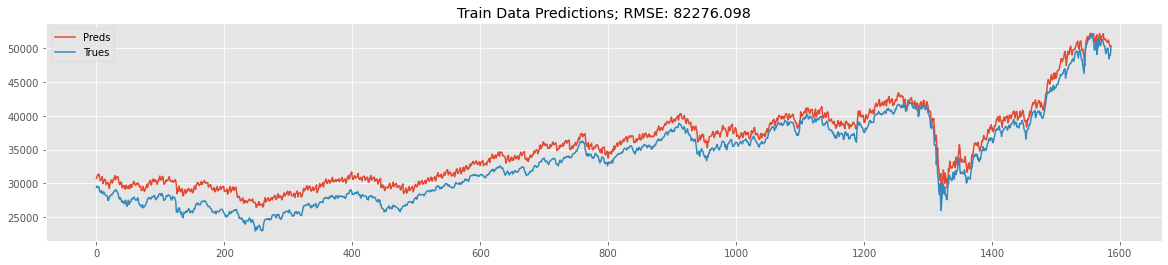

In [40]:
# Put the model in evaluation mode
model.eval()

# Predict on training dataset
train_preds, targs = [], []
for batch in train_dls:
    with torch.no_grad():
        series_input, exog_feats, targets = batch
        predictions = model.forward(series_input, exog_feats).squeeze(0).squeeze(-1)
        train_preds.append(predictions)
        targs.append(targets)

# Bring the predictions back to their original scale
ps = sc.inverse_transform(torch.cat(train_preds).unsqueeze(-1).numpy())[:, 0]
ts = sc.inverse_transform(torch.cat(targs).unsqueeze(-1).numpy())[:, 0]
prediction_error = (((ps - ts) ** 2).sum()) ** 0.5

# Plot the predictions
plt.figure(figsize=(20, 4))
plt.plot(ps); plt.plot(ts)
plt.title(f"Train Data Predictions; RMSE: {prediction_error:.3f}");
plt.legend(["Preds", "Trues"]);

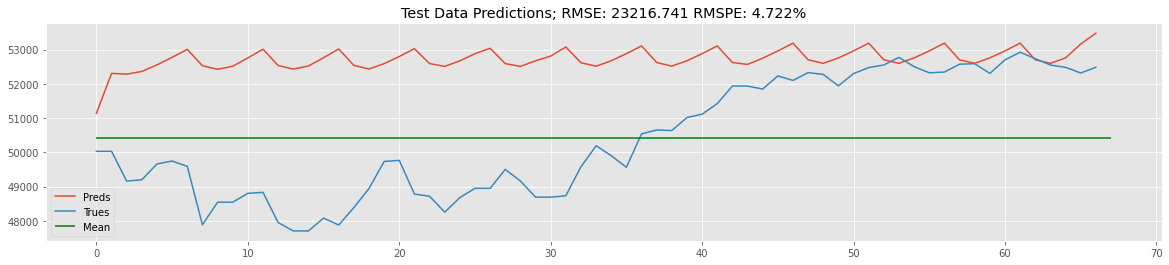

In [41]:
# Predict the sequence for test set
exogenous_feats = test_df[["Holiday", "DOW", "MOY", "Q"]].values.astype(np.float32)
last_sequence = train_df[["Close*"]].iloc[-seq_length:, :].values.reshape(-1).tolist()

with torch.no_grad():
    preds = model.predict_sequence(last_sequence, exogenous_feats)

# Get the predicitons back in the original scale
predictions = sc.inverse_transform(np.expand_dims(np.array(preds), 1)).reshape(-1)

# Extract the true values for test set
trues = test_df["Close*"].values

# Compute the prediciton error
prediction_error = (((predictions - trues) ** 2).sum()) ** 0.5
rmspe = (abs(predictions - trues) / trues).mean() * 100

# Plot the predictions
plt.figure(figsize=(20, 4))
plt.plot(predictions)
plt.plot(trues)
plt.hlines(trues.mean(), 0, len(test_df), color="g")
plt.title(f"Test Data Predictions; RMSE: {prediction_error:.3f} RMSPE: {rmspe:.3f}%")
plt.legend(["Preds", "Trues", "Mean"]);

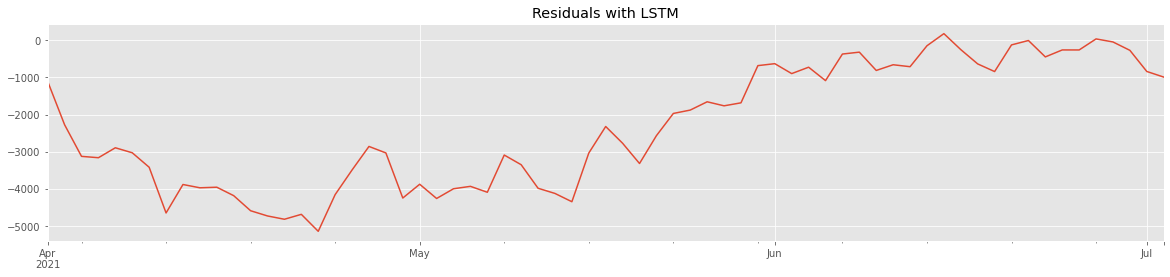

In [42]:
plt.figure(figsize = (20,4))
residuals = pd.Series(trues - predictions, index = test.index)
residuals.plot();
plt.title("Residuals with LSTM");

With LSTM model, we're almost always consistently overpredicting but close to the final time-period, we're predicting the results really closeby.

# Conclusion

- We modelled the BSE Index prediction problem as a time-series regression forecasting problem.
- We used three methods to predict the future
||Method|RMSE|RMSPE(%)|
|--|--|--|--|
|1|SARIMAX with 4 exogenous variables|16422|0.15|
|2|Prophet with a univariate time series|31917|7.5|
|3|LSTM with 4 exogenous variables|23216|4.722|

- Among all the three, SARIMAX gave the least RMSE followed by LSTM followed by prophet.
- **Amongst the models built, SARIMAX can give decent predictions and can be productionized, however, the prediction values become less and less accurate the more we delve into the future, so having a prediction of maybe the next 3-5 timeperiods could be sufficiently trusted.**

# Future Scope

- Hyperparameter optimization could be done on LSTMs to figure out a proper architecture
- A thorough literature review on using ML in technical analysis of stock prices/index to engineer richer features
- CNN based architectures/ Transformers for modelling the sequence of input values
- Ensemble of models